In [26]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        return torch.softmax(self.output_layer(x), dim=-1)
    
    def get_action(self, state):
        probs = self.forward(state)
        action = torch.multinomial(probs, 1).item()  # Sample an action
        log_prob = torch.log(probs.squeeze(0)[action])  # Get log prob of selected action
        return action, log_prob

# Rollout function to collect trajectories
def collect_trajectories(env, policy_net, episodes=10):
    trajectories = []
    
    for _ in range(episodes):
        state, info = env.reset()
        episode = []
        done = False
        while not done:
            # Move state tensor to the device
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action, log_prob = policy_net.get_action(state_tensor)
            next_state, reward, trunc, term, _ = env.step(action)
            done = trunc or term
            episode.append((state, action, reward, log_prob))
            state = next_state
        trajectories.append(episode)
    
    return trajectories

# Function to compute returns and advantages
def compute_advantages(trajectories, gamma=0.99):
    advantages = []
    returns = []
    
    for episode in trajectories:
        G = 0
        ep_returns = []
        
        for t in reversed(range(len(episode))):
            _, _, reward, _ = episode[t]
            G = reward + gamma * G
            ep_returns.insert(0, G)
        
        baseline = np.mean(ep_returns)
        ep_advantages = [G - baseline for G in ep_returns]
        
        advantages.extend(ep_advantages)
        returns.extend(ep_returns)
    
    return advantages, returns

# Natural policy gradient function
def compute_natural_policy_gradient(policy_net, trajectories, advantages):
    log_probs = []
    for episode in trajectories:
        for _, _, _, log_prob in episode:
            log_probs.append(log_prob)
    
    # Stack log probabilities and move to device
    log_probs = torch.stack(log_probs).to(device)
    # Convert advantages to tensor and move to device
    advantages = torch.FloatTensor(advantages).to(device)

    # Compute the policy gradient (sum of log-probs weighted by advantages)
    weighted_log_probs = log_probs * advantages
    gradients = autograd.grad(weighted_log_probs.sum(), policy_net.parameters(), create_graph=True)
    g = torch.cat([grad.view(-1) for grad in gradients])

    # Compute Fisher Information Matrix (F)
    fisher_matrix = torch.zeros(g.size(0), g.size(0), device=device)

    for i in range(len(log_probs)):
        grad_log_prob = autograd.grad(log_probs[i], policy_net.parameters(), retain_graph=True)
        flat_grad_log_prob = torch.cat([grad.view(-1) for grad in grad_log_prob])
        fisher_matrix += torch.ger(flat_grad_log_prob, flat_grad_log_prob)

    fisher_matrix /= len(log_probs)

    # Regularization for numerical stability (SVD decomposition)
    u, s, v = torch.svd(fisher_matrix)
    atol = 1e-6
    s_inv = torch.where(s > atol, 1.0 / s, torch.zeros_like(s, device=device))
    fisher_matrix_inv = torch.matmul(v, torch.diag(s_inv).float())
    fisher_matrix_inv = torch.matmul(fisher_matrix_inv, u.T)

    # Natural policy gradient step
    natural_gradient = torch.matmul(fisher_matrix_inv, g)
    
    return natural_gradient

# Update parameters using natural gradient
def update_policy(policy_net, natural_gradient, delta=0.01):
    # Detach the natural gradient to avoid tracking it in the computation graph
    natural_gradient_detached = natural_gradient.detach()
    
    # Flatten parameters and move to device
    flat_params = torch.cat([p.data.view(-1) for p in policy_net.parameters()]).to(device)
    
    # Normalizing the gradient for stable updates
    ng_norm = torch.dot(natural_gradient_detached, natural_gradient_detached).item()
    learning_rate = np.sqrt(delta / (ng_norm + 1e-8))
    flat_params += learning_rate * natural_gradient_detached
    
    # Update model's parameters
    index = 0
    for param in policy_net.parameters():
        param_length = param.view(-1).shape[0]
        param.data = flat_params[index:index + param_length].view(param.shape).data
        index += param_length

# Training loop
def train(env, policy_net, episodes=1000, delta=0.01):
    total_rewards = []
    for episode in range(episodes):
        trajectories = collect_trajectories(env, policy_net, episodes=3)
        
        # Calculate total reward for each trajectory
        episode_rewards = [sum([step[2] for step in tr]) for tr in trajectories]
        sum_reward = np.sum(episode_rewards)
        total_rewards.append(sum_reward)
        
        advantages, returns = compute_advantages(trajectories)
        natural_gradient = compute_natural_policy_gradient(policy_net, trajectories, advantages)
        update_policy(policy_net, natural_gradient, delta=delta)
        
        # Print the total reward every 50 episodes
        if episode % 50 == 0 or episode == episodes - 1:
            print(f'Episode {episode} complete | Total Reward: {sum_reward}')
        
    return total_rewards


In [28]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

policy_net = PolicyNetwork(input_dim, output_dim).to(device)

total_rewards = train(env, policy_net, episodes=300, delta=0.05)

env.close()


Episode 0 complete | Total Reward: 66.0
Episode 50 complete | Total Reward: 103.0
Episode 100 complete | Total Reward: 130.0
Episode 150 complete | Total Reward: 44.0
Episode 200 complete | Total Reward: 84.0
Episode 250 complete | Total Reward: 38.0
Episode 299 complete | Total Reward: 68.0


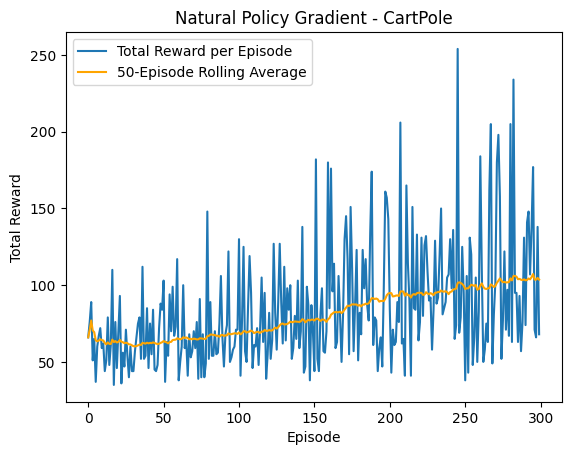

In [29]:
# Calculate the recent 50-episode interval average
window_size = 50
rolling_avg = [np.mean(total_rewards[max(0, i-window_size):(i+1)]) for i in range(len(total_rewards))]

# Plot the total rewards and rolling average over episodes
plt.plot(total_rewards, label='Total Reward per Episode')
plt.plot(rolling_avg, label=f'{window_size}-Episode Rolling Average', color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Natural Policy Gradient - CartPole')
plt.legend()
plt.show()
